In [5]:
from PIL import Image as PILImage
import pandas as pd
import pytesseract
import cv2
import numpy as np
from IPython.display import Image, display


## Image original

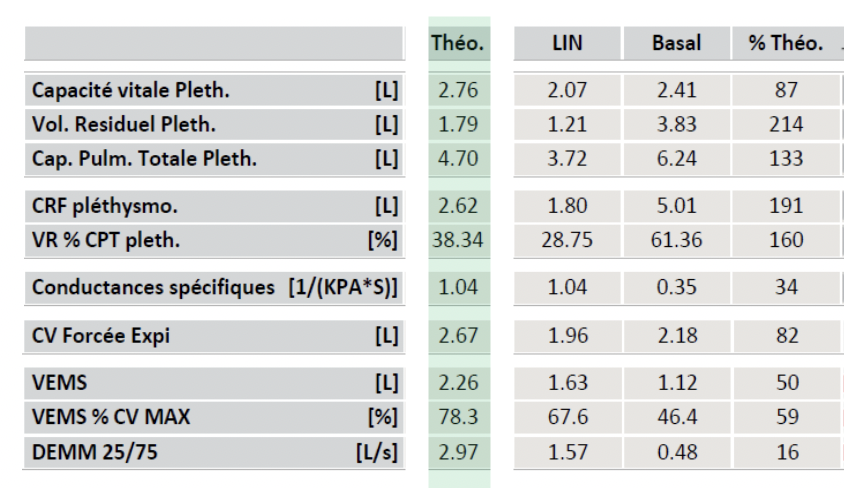

In [6]:
display(Image(filename="test2.png"))


## Pre-processing de l'image

In [7]:
image = cv2.imread('test2.png', cv2.IMREAD_GRAYSCALE)

# Augmenter la résolution en redimensionnant l'image (si nécessaire)
image = cv2.resize(image, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)

# Binarisation
_, image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Denoising
image = cv2.medianBlur(image, 1)

# Enregistrez l'image prétraitée si vous voulez la vérifier
cv2.imwrite('preprocessed_image.png', image)



True

## OCR avec tesseract basique

In [8]:
text = pytesseract.image_to_string(PILImage.open('preprocessed_image.png'))
print(text)

Capacité vitale Pleth. (L]
Vol. Residuel Pleth. (t]
Cap. Pulm. Totale Pleth. (t]
CRF pléthysmo. (L]
VR % CPT pleth. [%]

Conductances spécifiques [1/(KPA*S)]

CV Forcée Expi {t]
VEMS [L)
VEMS % CV MAX [%]

DEMM 25/75 [L/s]

Théo.

2.76
1.79
4.70

2.62
38.34

1.04
2.67

2.26
78.3
2.97

LIN

2.07
1.21
3.72

1.80
28.75

1.04
1.96

1.63
67.6
1.57

Basal

2.41
3.83
6.24

5.01
61.36

0.35
2.18

1.12
46.4
0.48

% Théo. .

87
214
133

191
160

34
82

50
59
16



## Processing du texte

In [9]:
# Splitting the text into sections for LIN, Basal, and % Théo
sections = text.split('\n')

In [10]:
def extract_section(sections, start_keyword=None, end_keyword=None):
    if start_keyword:
        start_idx = sections.index(start_keyword) + 1
    else:
        start_idx = 0
    
    if end_keyword:
        end_idx = sections.index(end_keyword)
    else:
        end_idx = len(sections)
    
    return [item for item in sections[start_idx:end_idx] if item]

parameters_section = extract_section(sections, None, 'Théo.')
theo_values = extract_section(sections, 'Théo.', 'LIN')
lin_values = extract_section(sections, 'LIN', 'Basal')
basal_values = extract_section(sections, 'Basal', '% Théo. .')
perc_theo_values = extract_section(sections, '% Théo. .')


In [13]:
df_final = pd.DataFrame({
    'Parameters': parameters_section,
    'Théo': theo_values,
    'LIN': lin_values,
    'Basal': basal_values,
    '% Théo': perc_theo_values
})

In [14]:
df_final

,Parameters,Théo,LIN,Basal,% Théo
0,Capacité vitale Pleth. (L],2.76,2.07,2.41,87
1,Vol. Residuel Pleth. (t],1.79,1.21,3.83,214
2,Cap. Pulm. Totale Pleth. (t],4.70,3.72,6.24,133
3,CRF pléthysmo. (L],2.62,1.80,5.01,191
4,VR % CPT pleth. [%],38.34,28.75,61.36,160
5,Conductances spécifiques [1/(KPA*S)],1.04,1.04,0.35,34
6,CV Forcée Expi {t],2.67,1.96,2.18,82
7,VEMS [L),2.26,1.63,1.12,50
8,VEMS % CV MAX [%],78.3,67.6,46.4,59
9,DEMM 25/75 [L/s],2.97,1.57,0.48,16
